In [1]:
import torch
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

# Đảm bảo reproducibility
torch.manual_seed(1)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {device}")


Mounted at /content/drive
✅ Using device: cuda


1 Data

In [2]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.75, scale=(0.01, 0.3), ratio=(1.0, 1.0), value=0, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset paths
train_path = "/content/drive/MyDrive/Colab Notebooks/Transfer learning/data1000/train"
val_path = "/content/drive/MyDrive/Colab Notebooks/Transfer learning/data1000/validation"

# Datasets
train_data = datasets.ImageFolder(train_path, transform=train_transform)
test_data = datasets.ImageFolder(val_path, transform=test_transform)

# DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

print(f"✅ Dataset loaded: {len(train_data)} training samples, {len(test_data)} validation samples.")


✅ Dataset loaded: 2000 training samples, 1000 validation samples.


2 Model

In [3]:
# Load the pretrained VGG16 model
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
f_extractor = vgg16.features

# Freeze the feature extraction part (all layers up to the classifier)
for param in f_extractor.parameters():
    param.requires_grad = False

for name, module in f_extractor.named_modules():
    if hasattr(module, 'parameters'):
        is_trainable = any(param.requires_grad for param in module.parameters())
        print(f"{name}: {'Trainable' if is_trainable else 'Not trainable'}")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 152MB/s]


: Not trainable
0: Not trainable
1: Not trainable
2: Not trainable
3: Not trainable
4: Not trainable
5: Not trainable
6: Not trainable
7: Not trainable
8: Not trainable
9: Not trainable
10: Not trainable
11: Not trainable
12: Not trainable
13: Not trainable
14: Not trainable
15: Not trainable
16: Not trainable
17: Not trainable
18: Not trainable
19: Not trainable
20: Not trainable
21: Not trainable
22: Not trainable
23: Not trainable
24: Not trainable
25: Not trainable
26: Not trainable
27: Not trainable
28: Not trainable
29: Not trainable
30: Not trainable


In [4]:
model = nn.Sequential(f_extractor,
                      nn.Flatten(),
                      nn.Dropout(0.3),
                      nn.Linear(512*7*7, 512),
                      nn.ReLU(),
                      nn.Dropout(0.3),
                      nn.Linear(512, 2))



model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

3 Train, Evaluate

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [6]:
def train_one_epoch(model, criterion, optimizer, loader):
    model.train()
    total, running_loss, running_correct = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc

def evaluate_one_epoch(model, criterion, loader):
    model.eval()
    total, test_loss, running_correct = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = test_loss / len(loader)
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


In [7]:
# Training loop
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

num_epochs = 10

print("⚙️ Starting training...", flush=True)

for epoch in range(num_epochs):

    train_loss, train_acc = train_one_epoch(model, criterion, optimizer, train_loader)
    test_loss, test_acc = evaluate_one_epoch(model, criterion, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1:02d}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} || ",

          flush=True)

print("✅ Training completed.", flush=True)


⚙️ Starting training...
[Epoch 01/10] Train Loss: 0.1620 | Train Acc: 0.9270 || Test Loss: 0.0323 | Test Acc: 0.9850 || 
[Epoch 02/10] Train Loss: 0.0613 | Train Acc: 0.9780 || Test Loss: 0.0273 | Test Acc: 0.9890 || 
[Epoch 03/10] Train Loss: 0.0518 | Train Acc: 0.9810 || Test Loss: 0.0341 | Test Acc: 0.9860 || 
[Epoch 04/10] Train Loss: 0.0343 | Train Acc: 0.9875 || Test Loss: 0.0333 | Test Acc: 0.9870 || 
[Epoch 05/10] Train Loss: 0.0394 | Train Acc: 0.9850 || Test Loss: 0.0501 | Test Acc: 0.9840 || 
[Epoch 06/10] Train Loss: 0.0320 | Train Acc: 0.9880 || Test Loss: 0.0328 | Test Acc: 0.9860 || 
[Epoch 07/10] Train Loss: 0.0390 | Train Acc: 0.9830 || Test Loss: 0.0378 | Test Acc: 0.9870 || 
[Epoch 08/10] Train Loss: 0.0320 | Train Acc: 0.9890 || Test Loss: 0.0356 | Test Acc: 0.9860 || 
[Epoch 09/10] Train Loss: 0.0365 | Train Acc: 0.9850 || Test Loss: 0.0373 | Test Acc: 0.9870 || 
[Epoch 10/10] Train Loss: 0.0231 | Train Acc: 0.9905 || Test Loss: 0.0346 | Test Acc: 0.9860 || 
✅ Trai

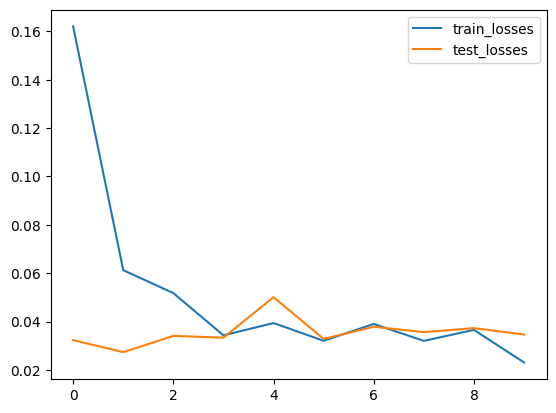

In [8]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

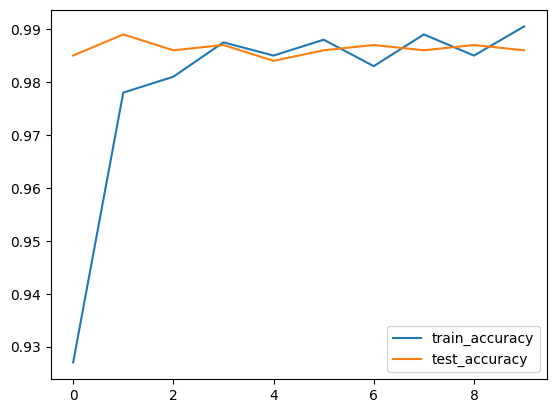

In [9]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()
print("Cache cleared.")

The predicted class for the image is: dogs


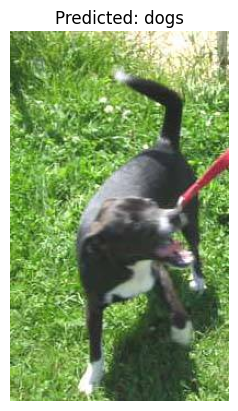

In [12]:
from PIL import Image

image_path = "/content/drive/MyDrive/Colab Notebooks/Transfer learning/data1000/validation/dogs/dog.2000.jpg"
image = Image.open(image_path)

# Apply the same transformations as the test set
input_image = test_transform(image).unsqueeze(0).to(device)

# Make a prediction
model.eval()
with torch.no_grad():
    output = model(input_image)
    _, predicted_class = torch.max(output.data, 1)

# Get the class name
class_names = train_data.classes
predicted_class_name = class_names[predicted_class.item()]

print(f"The predicted class for the image is: {predicted_class_name}")

# Display the image
plt.imshow(image)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()

In [13]:
# Define the path to save the model
model_save_path = "/content/drive/MyDrive/Colab Notebooks/Transfer learning/vgg16_transfer_learning_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"✅ Model saved to: {model_save_path}")

✅ Model saved to: /content/drive/MyDrive/Colab Notebooks/Transfer learning/vgg16_transfer_learning_model.pth
